In [1]:
import sys
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages')
import os 
import pickle
import age_gender_predictor
from collections import defaultdict
import re
from tabulate import tabulate
from datetime import datetime, timedelta
import math
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import pytz
import json

## Load Regular User

In [3]:
def checkFolderFile(folder):
    return os.listdir(folder)

In [4]:
regular_clean = []
regular_folder = './Regular/'
for regular_file in checkFolderFile(regular_folder):
    regular_clean.append(pd.read_pickle(regular_folder+regular_file))

In [5]:
len(regular_clean)

268

In [6]:
long_regular_clean = []
regular_folder = './Regular_timeline/'
for regular_file in checkFolderFile(regular_folder):
    long_regular_clean.append(pd.read_pickle(regular_folder+regular_file))

In [7]:
len(long_regular_clean)

409

## Load Different Time Period

In [411]:
regular_month15,regular_month12, regular_month9,regular_month6, regular_month3, regular_month2 = [], [], [], [], [], []
regular_varable = [regular_month15,regular_month12, regular_month9,regular_month6, regular_month3, regular_month2]
regular_folder = ['./Regular_15month/','./Regular_12month/','./Regular_9month/','./Regular_6month/','./Regular_3month/','./Regular_2month/']
for i, folder in enumerate(regular_folder):
    for regular_file in checkFolderFile(folder):
        regular_varable[i].append(pd.read_pickle(folder+regular_file))

In [412]:
len(regular_month3)

257

## Load BD

In [43]:
bd_clean = []
bd_folder = './Bipolar/bd_shift2week/'
for bd_file in checkFolderFile(bd_folder):
    bd_clean.append(pd.read_pickle(bd_folder+bd_file))

In [44]:
len(bd_clean)

276

In [10]:
long_bd_clean = []
bd_folder = './Bipolar_timeline/'
for bd_file in checkFolderFile(bd_folder):
    long_bd_clean.append(pd.read_pickle(bd_folder+bd_file))

In [11]:
len(long_bd_clean)

165

## Load Different Time Period

In [371]:
bd_month15, bd_month12, bd_month9, bd_month6, bd_month3, bd_month2 = [], [], [], [], [], []
bd_varable = [bd_month15, bd_month12, bd_month9, bd_month6, bd_month3, bd_month2]
bd_folder = ['./Bipolar_15month/','./Bipolar_12month/','./Bipolar_9month/','./Bipolar_6month/','./Bipolar_3month/','./Bipolar_2month/']
for i, folder in enumerate(bd_folder):
    for bd_file in checkFolderFile(folder):
        bd_varable[i].append(pd.read_pickle(folder+bd_file))

In [372]:
len(bd_month2)

133

## Group together

In [413]:
groups = [ regular_month2, bd_month2, regular_month3, bd_month3, regular_month6, bd_month6,
          regular_month9, bd_month9, regular_month12, bd_month12, regular_month15, bd_month15]
group_names = ["Regular_2", "Bipolar_2", "Regular_3", "Bipolar_3", "Regular_6", "Bipolar_6",
               "Regular_9", "Bipolar_9", "Regular_12", "Bipolar_12", "Regular_15", "Bipolar_15"]

In [414]:
#Statistics facts of experimental data

headers = ["Group","Users", "Tweets", "Average tweets"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    tweets_num = sum([timeSeries.shape[0] for timeSeries in group])
    users_num = len(group)
    average_tweets_num = tweets_num / users_num
    contents.append([group_name, users_num, tweets_num, average_tweets_num])
    
print(tabulate(contents, headers=headers))

Group         Users    Tweets    Average tweets
----------  -------  --------  ----------------
Regular_2       260     67485               259
Bipolar_2       133    136837              1028
Regular_3       257     89141               346
Bipolar_3       135    226460              1677
Regular_6       267    136481               511
Bipolar_6       124    353559              2851
Regular_9       289    170380               589
Bipolar_9       117    481392              4114
Regular_12      295    207008               701
Bipolar_12      111    586656              5285
Regular_15      278    213394               767
Bipolar_15      111    692941              6242


## Age Gender

In [415]:
#Age and gender Distribution
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

In [416]:
headers = ["Group","Male users", "Female users", "Average age"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    users_num = float(len(group))
    users_gender = [getGender(timeSeries) for timeSeries in group]
    users_age = [getAge(timeSeries) for timeSeries in group]
    male_ratio = len([gender for gender in users_gender if gender < 0]) / users_num
    female_ratio = 1 - male_ratio
    average_age = sum(users_age) / users_num
    contents.append([group_name, male_ratio, female_ratio, average_age])
print(tabulate(contents, headers=headers))

Group         Male users    Female users    Average age
----------  ------------  --------------  -------------
Regular_2       0.503846        0.496154        29.8115
Bipolar_2       0.24812         0.75188         24.8592
Regular_3       0.478599        0.521401        30.1312
Bipolar_3       0.207407        0.792593        24.4102
Regular_6       0.453184        0.546816        30.6582
Bipolar_6       0.233871        0.766129        24.0319
Regular_9       0.477509        0.522491        30.4293
Bipolar_9       0.205128        0.794872        24.3903
Regular_12      0.471186        0.528814        29.7549
Bipolar_12      0.207207        0.792793        24.4096
Regular_15      0.467626        0.532374        30.2141
Bipolar_15      0.189189        0.810811        24.4064


## Social

In [417]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    if total_tweets == 0: return 0.0
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": [], "long_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
        try:
            social_features["long_tweets_rate"].append(total_dict[str(timeSeries['name'][0])])
        except:
            print('No found in long_term ' + str(timeSeries['name'][0]))
            social_features["long_tweets_rate"].append(0.0)
    return social_features

def getGBSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        
    return social_features

def getNoLongSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
        
    return social_features

In [418]:
header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    tweets_rate = np.mean([getTweetRate(timeSeries) for timeSeries in group])
    mention_rate = np.mean([getMentionRate(timeSeries) for timeSeries in group])
    unique_mentions = np.mean([getUniqueMentions(timeSeries) for timeSeries in group])
    frequent_mention = np.mean([getFrequentMentions(timeSeries) for timeSeries in group]) 
    late_tweets_rate = np.mean([getLateTweetRate(timeSeries) for timeSeries in group])
    content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
    contents.append(content)


print("\n======Mean Distribution======\n")

print(tabulate(contents, headers=header,))


======Mean Distribution======

              tweets_rate    late_tweets_rate    mention_rate    unique_mentions    frequent_mentions
----------  -------------  ------------------  --------------  -----------------  -------------------
Regular_2         4.49298            0.414508        0.431381            53.6769              11.5
Bipolar_2        17.956              4.04942         0.396966           117.489               36.3308
Regular_3         3.99729            0.338119        0.421551            71.3307              15.7004
Bipolar_3        17.4618             3.85854         0.402067           169.622               54.1556
Regular_6         2.85013            0.310132        0.427669            92.4981              20.8989
Bipolar_6        15.2578             3.56412         0.409098           267.5                 84.9758
Regular_9         2.17571            0.256841        0.421164           103.239               23.8062
Bipolar_9        14.7925             3.75256         

In [419]:
# header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
# contents = []
# for i, timeSeries in enumerate(regular_clean):
# #     content = [i]
#     content = [str(timeSeries['name'][0])]
#     tweets_rate = getTweetRate(timeSeries)
#     mention_rate = getMentionRate(timeSeries)
#     unique_mentions = getUniqueMentions(timeSeries)
#     frequent_mention = getFrequentMentions(timeSeries)
#     late_tweets_rate = getLateTweetRate(timeSeries)
#     content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
#     contents.append(content)
# print("\n======Mean Distribution======\n")
# print(tabulate(contents, headers=header,))

## Polarity Feature

In [420]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

In [421]:
headers = ["Group","Positive Ratio","Negative Ratio", "Flip Ratio", "Positive Combos", "Negative Combos"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratio_mean = np.mean([getPositiveRatio(timeSeries) for timeSeries in group])
    negative_ratio_mean = np.mean([getNegativeRatio(timeSeries) for timeSeries in group])
    flips_ratio_mean = np.mean([getFlipsCount(timeSeries) / float(len(timeSeries)) for timeSeries in group])
    negative_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=-1) / float(len(timeSeries)) for timeSeries in group])
    positive_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=1) / float(len(timeSeries)) for timeSeries in group])
    
    contents.append([group_name, positive_ratio_mean, negative_ratio_mean, flips_ratio_mean, positive_combos_ratio, negative_combos_ratio])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group         Positive Ratio    Negative Ratio    Flip Ratio    Positive Combos    Negative Combos
----------  ----------------  ----------------  ------------  -----------------  -----------------
Regular_2          0.223811           0.108312    0.00432236         0.0332145          0.00439527
Bipolar_2          0.0982161          0.172691    0.00578583         0.00643929         0.0186712
Regular_3          0.214817           0.109222    0.00470779         0.030426           0.0031437
Bipolar_3          0.097095           0.173152    0.00561589         0.00620796         0.0191976
Regular_6          0.223818           0.112794    0.00440139         0.0323001          0.00564947
Bipolar_6          0.100064           0.167476    0.00546895         0.00615428         0.0177763
Regular_9          0.225617           0.115473    0.00429804         0.0266098          0.00338021
Bipolar_9          0.100268           0.16423     0.0052977          0.00738731         0.0164242
Regular_12   

In [422]:
headers = ["Group","Positive Ratio Mean","Positive Ratio STD", "Negative Ratio Mean", "Negative Ratio STD"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratios = [getPositiveRatio(timeSeries) for timeSeries in group]
    negative_ratios = [getNegativeRatio(timeSeries) for timeSeries in group]
    positive_ratio_mean = np.mean(positive_ratios)
    negative_ratio_mean = np.mean(negative_ratios)
    positive_ratio_std = np.std(positive_ratios)
    negative_ratio_std = np.std(negative_ratios)

    contents.append([group_name, positive_ratio_mean, positive_ratio_std, negative_ratio_mean, negative_ratio_std])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group         Positive Ratio Mean    Positive Ratio STD    Negative Ratio Mean    Negative Ratio STD
----------  ---------------------  --------------------  ---------------------  --------------------
Regular_2               0.223811              0.158477                0.108312             0.0823516
Bipolar_2               0.0982161             0.0590432               0.172691             0.0754925
Regular_3               0.214817              0.145268                0.109222             0.0795563
Bipolar_3               0.097095              0.0570975               0.173152             0.0747214
Regular_6               0.223818              0.144994                0.112794             0.0837599
Bipolar_6               0.100064              0.0644627               0.167476             0.0670088
Regular_9               0.225617              0.142528                0.115473             0.0817134
Bipolar_9               0.100268              0.0555564               0.16423            

## Emotion

In [423]:
def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



In [424]:
emotions = ["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]

headers = ["Group"] + emotions
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    emotions_counts = getGroupEmotions(group)
    for emotion in emotions:
        emotion_ratio = "{}%".format(round(np.mean(emotions_counts[emotion])*100, 2))
        
        content.append(emotion_ratio)
    contents.append(content)
    
print("\n======Eight Emotional Features======\n")

print("\n======Distribution======\n")

print(tabulate(contents, headers=headers,))



======Eight Emotional Features======


======Distribution======

Group       joy     sadness    fear    anticipation    anger    trust    disgust    surprise
----------  ------  ---------  ------  --------------  -------  -------  ---------  ----------
Regular_2   16.17%  26.27%     6.67%   13.84%          6.98%    15.14%   11.69%     3.25%
Bipolar_2   13.73%  28.14%     4.09%   14.27%          13.26%   5.62%    16.5%      4.39%
Regular_3   15.99%  26.33%     6.78%   14.04%          7.08%    14.58%   11.92%     3.29%
Bipolar_3   13.69%  28.46%     4.21%   14.02%          13.15%   5.39%    16.67%     4.42%
Regular_6   16.48%  26.13%     6.88%   13.61%          7.03%    14.9%    11.8%      3.18%
Bipolar_6   13.81%  28.0%      4.07%   14.31%          13.21%   5.41%    16.7%      4.51%
Regular_9   16.87%  25.81%     6.62%   13.84%          7.14%    14.57%   11.96%     3.19%
Bipolar_9   14.15%  27.34%     4.19%   14.38%          13.05%   5.65%    16.65%     4.59%
Regular_12  17.09%  25.97%

## Long Term Feature

In [374]:
# 8 weeks sliding windows, move 1 week per time
def slideWindows(timeline, start):
    
    limit = start + timedelta(weeks=8)
    
    status = False
    if timeline.index[-1] < limit: status = True
    
    new_start = start + timedelta(weeks=1)
    
    return timeline[timeline.index < limit], new_start, timeline[timeline.index > new_start],status
    
        
def getTimeSeries(timeline):
    timeSeries_list = []
    start = timeline.index[0]
    
    while True:
        timeSeries, start, timeline, status = slideWindows(timeline, start)
        timeSeries_list.append(timeSeries)
        if status: break
            
    return timeSeries_list

In [375]:
bd_dict = {}
regular_dict = {}
for i, bd_timeline in enumerate(long_bd_clean):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(bd_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    bd_dict[str(bd_timeline['name'][0])] = np.ptp(tweets_rate_array)
    
for i, regular_timeline in enumerate(long_regular_clean):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(regular_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    regular_dict[str(regular_timeline['name'][0])] = np.ptp(tweets_rate_array)

total_dict = {}
total_dict.update(bd_dict)
total_dict.update(regular_dict)
# del bd_dict
# del regular_dict

In [376]:
len(total_dict)

574

In [377]:
len(bd_dict)

165

In [378]:
len(regular_dict)

409

### LIWC

In [425]:
#Functions for LIWC and POL features extraction:
def loads_LIWC():
    f = open("LIWC/categories.json", 'r')
    categories = json.load(f)
    f = open("LIWC/words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories

LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC()

def getLIWC_user(timeSeries):
    LIWC_counts = {}
    features = np.zeros(len(LIWC_categories),dtype=int)
    
    texts= timeSeries["text"].values
    for text in texts:
        words = text.strip().split()
        for word in words:
            category_indices = LIWC_words.get(word,[])
            if category_indices == []:
                current_dict = LIWC_patterns_categories
                for char in word[:-1]:
                    current_dict = current_dict.get(char,[])
                    if isinstance(current_dict,list):
                        category_indices = current_dict                            
                        break

            for category_index in category_indices:
                category_name = LIWC_categories[category_index]
                LIWC_counts[category_name] = LIWC_counts.get(category_name,0) + 1

    for category_name in LIWC_counts:
        LIWC_counts[category_name] /= timeSeries.shape[0]
    
    return LIWC_counts

def getLIWC_group(group):
    LIWC_counts = {}
    users_num = len(group)
    for category in LIWC_categories.values():
        LIWC_counts[category] = []
    for timeSeries in group:
        user_LIWC_count = getLIWC_user(timeSeries)
      
        for category in LIWC_categories.values():
            LIWC_counts[category].append(user_LIWC_count.get(category,0))
            
    return LIWC_counts

## Group Class

In [426]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib import rcParams
from random import randint
from operator import itemgetter 
import time
rcParams['figure.figsize'] = 12, 8

In [427]:
# function to delete url
def del_url(line):
    return re.sub(r'(\S*(\.com).*)|(https?:\/\/.*)', "", line)

In [428]:
#Wrap group to be object
class Group(object):
    def __init__(self, group_name, group_data_list):
        self.name = group_name
        self.timeSerieses_list = group_data_list
        
    def getName(self):
        return self.name
    
    def getSize(self):
        return len(self.timeSerieses_list)
    
    def getTexts(self, tail_k = "all"):
        if tail_k == "all":
            return ["\n".join(map(del_url, timeSeries["text"].values)) for timeSeries in self.timeSerieses_list]
        else:
            return ["\n".join(map(del_url, timeSeries["text"].tail(tail_k).values)) for timeSeries in self.timeSerieses_list]
    
    def getGroup(self, tail_k="all"):
        if tail_k =="all":
#             return [timeSeries for timeSeries in self.timeSerieses_list if str(timeSeries['name'][0]) in total_dict]
            
            return self.timeSerieses_list
        else:
            return [timeSeries.tail(tail_k) for timeSeries in self.group]

In [429]:
# bipolar_group = Group("Bipolar", bd_clean)
# regular_group = Group("Regular", regular_clean)

# long_bipolar_group = Group("Long_Bipolar", long_bd_clean)
# long_regular_group = Group("Long_Regular", long_regular_clean)

In [430]:
bipolar2_group = Group("Bipolar_2", bd_month2)
regular2_group = Group("Regular_2", regular_month2)

bipolar3_group = Group("Bipolar_3", bd_month3)
regular3_group = Group("Regular_3", regular_month3)

bipolar6_group = Group("Bipolar_6", bd_month6)
regular6_group = Group("Regular_6", regular_month6)

bipolar9_group = Group("Bipolar_9", bd_month9)
regular9_group = Group("Regular_9", regular_month9)

bipolar12_group = Group("Bipolar_12", bd_month12)
regular12_group = Group("Regular_12", regular_month12)

bipolar15_group = Group("Bipolar_15", bd_month15)
regular15_group = Group("Regular_15", regular_month15)

In [431]:
def getCategories(group):
    '''
    Input  : the group (Class) of user
    Output : Dictionary of feature name and feature's group pairs

    e.g.
    'tweets_rate': 'GBSocial'
    'unique_mentions': 'GBSocial'
    '''
    name2category = {}
    names = ["Emotions", "Polarity", "AgeGender", "LIWC",
             "LongSocial", "lateSocial", "GBSocial"]
    methods = [getGroupEmotions, getPolarity, getAgeGender, getLIWC_group, 
               getSocialFeature_group,  getNoLongSocialFeature_group, getGBSocialFeature_group]
    for i, method in enumerate(methods):
        if method == getLIWC_group:
            feature = {"LIWC_"+key: value for key, value in method(group.getGroup()).items()}
        else:
            feature = method(group.getGroup())
        for key in feature:
            name2category[key] = names[i]
    return name2category

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getGroupEmotions, getPolarity, getAgeGender, getLIWC_group, 
               getSocialFeature_group,  getNoLongSocialFeature_group, getGBSocialFeature_group]
    for method in methods:
        if method == getLIWC_group:
            LIWC_feature_set = {"LIWC_"+key: value for key, value in method(group.getGroup(tail_k)).items()}
            feature_set.update(LIWC_feature_set)
        else:
            feature_set.update(method(group.getGroup()))
    return feature_set

## Classifier

### The TF-IDF models are trained in the following class

In [432]:
#A TF-IDF class to implement TF-IDF extraction and model training.

def XYGenerator(labeled_data):
    X, Y = labeled_data[0]
    
    for x, y in labeled_data[1:]:
        try:        
            X = np.concatenate((X, x))
        except:
            X = vstack([X, x])
            
        Y = np.concatenate((Y, y))
    
    return X, Y


class TextFeatureGroups(object):
    def __init__(self, base, groups, model = "Tf-iDF"):
        self.base = base
        self.groups = groups
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
       
        base_texts = base.getTexts()
        self.text_models = []
        self.classifiers = []
        for group in groups:
            group_texts = group.getTexts()
            total_texts = base_texts  + group_texts
            if model == "Tf-iDF":
                text_model = TfidfVectorizer(stop_words="english", ngram_range = (1,2))
            text_model.fit(total_texts)    
            X = text_model.fit_transform(total_texts)  
            Y = np.array([0] * base.getSize() + [1]*group.getSize(), dtype=int)
            classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
            classifier.fit(X,Y)
            self.classifiers.append(classifier)
            self.text_models.append(text_model)
    
    def getTopFeatures(self, name, k=50):
        index = self.name_to_index[name]
        text_model = self.text_models[index]
        classifier = self.classifiers[index]
        feature_indicies = np.argsort(classifier.feature_importances_)
        vector2word = text_model.get_feature_names()
        top_words = []
        for i in range(k):
            vector = feature_indicies[-i-1]
            word = vector2word[vector]
            top_words.append(word)
        return top_words
    

    def getGroup(self,name):
        index = self.name_to_index[name]
        return self.group[index]
            
    def classify(self,name, group):
        index = self.name_to_index[name]
        classifier = self.classifiers[index]
        text_model = self.text_models[index]
        X = text_model.transform(group.getTexts())
        return classifier.predict(X) 
    
    def getPrecision(self,name, tail_k="all", classifier = "default", n_fold=10):
        index = self.name_to_index[name]
        group = self.groups[index]
        if classifier == "default":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        #classifier = SVC(probability=True)
        #X = self.text_models[index].transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        text_model = self.text_models[index]
        raw_X = self.base.group + group.group
        Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())
        precisions = []
        
        complete_X = text_model.transform(self.base.getTexts()+group.getTexts())
        tailed_X =  text_model.transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)

        return np.mean(precisions)
        
    
    def getLabelsScores(self, name, classifier, n_fold, consider_time = "short"):
        index = self.name_to_index[name]
        group = self.groups[index]

        SCORES = np.array([])
        LABELS = np.array([])

        
#         Based may change by situation
        if consider_time == "short":
            X = self.text_models[index].transform(self.base.getTexts()+group.getTexts())
            Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())  
        elif consider_time == "long":
            X = self.text_models[index].transform(self.groups[0].getTexts()+group.getTexts())
            Y =  np.array([0] * self.groups[0].getSize() + [1] * group.getSize())  
        else:
            X = self.text_models[index].transform(self.groups[0].getTexts()+group.getTexts())
            Y =  np.array([0] * self.groups[self.name_to_index["Regular_" + str(consider_time)]].getSize() + [1] * group.getSize())  

        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
        
    def renderPrecisionRecall(self, colors=['r','g','b',"y","c","m","#f4b642","#777777"], n_fold = 10):
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')

        for g, group in enumerate(self.groups):
            SCORES, LABELS,(X_train, X_test,Y_train, Y_test) = self.getLabelsScores(group.getName(), classifier ,n_fold)

            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)

            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test

            print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,group.getName()))
            print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,group.getName()))
            plt.plot(recall, precision, label=group.getName() , color=colors[g],linewidth=3)

        plt.legend(loc="lower right")
        plt.show()


# Build the TF-IDF class
tfidf_groups = TextFeatureGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, regular15_group, 
                                                  bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group])

# Extract Top 10 keywords by TF-IDF model for Bipolar and BPD
print(tfidf_groups.getTopFeatures("Bipolar_2"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_3"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_6"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_9"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_12"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_15"))

[u'bipolar', u'diagnosed', u'diagnosed bipolar', u'friend', u'sure', u'really', u'really just', u'lover', u'guess', u'disorder', u'annoying', u'don', u'forgot', u'hurt', u'dying', u'pretty', u'isn', u'face', u'lyrics', u'seen', u'worse', u'omg', u'halloween', u'weird', u'ill', u'empty_tweets', u'people don', u'weight', u'laying', u'scream', u'actually', u'know', u'best friends', u'live', u'life', u'sad', u'randomly', u'like', u'relationship', u'ways', u'idea', u'pills', u'really want', u'racist', u'love', u'bullshit', u'fighting', u'blanket', u'learned', u'reading']



[u'bipolar', u'sad', u'head', u'jesus', u'crying', u'people think', u'just got', u'means', u'christmas', u'doctor', u'sexy', u'mean', u'health', u'yesterday', u'drug', u'voice', u'tried', u'ex', u'met', u'kill', u'disorder', u'later', u'unless', u'don know', u'hahahaha', u'forever', u'damn', u'date', u'amp', u'said', u'woke', u'issues', u'hell', u'best friend', u'lady', u'piece shit', u'wake', u'gift', u'emotional', u'di

In [433]:
class POLFeaturerGroups(object):
    
    @staticmethod
    def transform(self, ):
        features_dict = getAllFeature(group)
        
    
    def __init__(self, base, groups):
        feature2categories = getCategories(base)
        self.groups = groups
        self.base = base
        self.categories = set(feature2categories.values())
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
        self.base_name = base.getName()
        self.index2feature = []
        base_feature_dict = getAllFeature(base)
        self.base_feature = np.zeros((base.getSize(),len(base_feature_dict)), dtype = float)
#         
        for name, values in base_feature_dict.items():
            cursor = len(self.index2feature)
            self.base_feature[:,cursor] = values
            category = feature2categories[name]
            self.index2feature.append((name, category))
        
        self.features = [self.group2feature(group) for group in groups]
#         user_name
        self.groups_user_name = []
        for group in groups:
            group_user_name = []
            for timeSeries in group.getGroup():
                group_user_name.append(timeSeries['name'][0])
            self.groups_user_name.append(group_user_name)
        
        self.base_user_name = []
        for timeSeries in base.getGroup():
            self.base_user_name.append(timeSeries['name'][0])
            
    def addgroup(self, group):
        group_user_name = []
        for timeSeries in group.getGroup():
            group_user_name.append(timeSeries['name'][0])
        self.groups_user_name.append(group_user_name)
        
        self.name_to_index = {group.getName(): len(name_to_index)}
        print(group.getName() + ' is added!')
        return True
        
    def group2feature(self, group, tail_k="all", selection = "all"):
        features_dict = getAllFeature(group, tail_k)
        feature = np.zeros((group.getSize(),len(self.index2feature)),dtype=float)
        for cursor, (name,category) in enumerate(self.index2feature):
            value = features_dict[name]
            feature[:,cursor] = value
        if selection == "all":
            return feature
        else:
            return feature[:,selection]   

    def getPrecision(self,name,selection="all",tail_k="all",n_fold=10,classifier = "forest"):
        complete_X, Y = self.getLabeledData(name, selection)
        index = self.name_to_index[name]
        group = self.groups[index]
        tailed_X = preprocessing.scale(self.group2feature(self.base + group, tail_k=tail_k, selection = selection))
        complete_X = preprocessing.scale(complete_X)
        
        tailed_X[np.isinf(tailed_X)] = 0
        tailed_X[np.isnan(tailed_X)] = 0
        
        precisions = []
        if classifier == "forest":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
  
        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            imputer = Imputer()
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)
            
        return np.mean(precisions)
            
    def getLabeledData(self,name, selection = "all", consider_time = "short"):
#         print('Get Label Data - Name: {}, Consider Time: {}, Selection: {}'.format(name, consider_time, selection))
        if selection is "all":
            selection = xrange(len(self.index2feature))
            
        if consider_time == "short":        
            base_feature = self.base_feature[:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]
            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
    #         Y = np.array([(0,-1)]*base_length + [(1,i) for i,_ in enumerate(self.getGroupUserName())])
            Y = np.array([(0,i) for i,_ in enumerate(self.getBaseUserName())] + [(1,i) for i,_ in enumerate(self.getGroupUserName(1))])
            return X, Y
        elif consider_time == "long":
            base_index = self.name_to_index["Regular_15"]
            base_feature = self.features[base_index][:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]

            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
            Y = np.array([(0,i) for i,_ in enumerate(self.getGroupUserName(base_index))] + [(1,i) for i,_ in enumerate(self.getGroupUserName(index))])
            return X, Y
        else:
            base_index = self.name_to_index["Regular_"+str(consider_time)]
            base_feature = self.features[base_index][:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]

            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
            Y = np.array([(0,i) for i,_ in enumerate(self.getGroupUserName(base_index))] + [(1,i) for i,_ in enumerate(self.getGroupUserName(index))])
            return X, Y 

            
    def getFeatureImportance_all(self,name):
        X, Y = self.getLabeledData(name)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    def getFeature(self, name, selection="all"):
        if selection is "all":
            selection = list(range(len(self.index2feature)))
        index = self.name_to_index[name]
        feature =  self.features[index]
        return feature[:, selection]
    
    def classify(self,name, target_name, selection="all"):
        X, Y = self.getLabeledData(name, selection)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        test_x = self.getFeature(target_name,selection)
        return classifier.predict(test_x)
       
    def getLabelsScores(self, name, classifier, n_fold, selection, consider_time = "short"):
        SCORES = np.array([])
        LABELS = np.zeros(shape=(0,2))
        
        X, Y = self.getLabeledData(name, selection, consider_time)
        sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test           = X[train_index], X[test_index]
            Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]
            Y_train_name, Y_test_name = Y[train_index][:,1], Y[test_index][:,1]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y[test_index]))
        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name)
    
    def renderPrecisionRecall_all(self, name, colors=['r','g','b',"y","c","m","#f4b642","#777777"], n_fold = 100, consider_time = "short"):
        classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        ax.title.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        categories = list(self.categories) + ["All"]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category == feature_category]
            
            SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name) = self.getLabelsScores(name, classifier,n_fold, selection, consider_time)
            precision, recall, _ = precision_recall_curve(LABELS[:,0], SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS[:,0], SCORES)
            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test
           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=2)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()

    def getSeperateScores(self, name, classifier, n_fold, selection):
        SCORES = np.array([])
        LABELS = np.array([])

        X, Y = self.getLabeledData(name, selection)

        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
    
    def getGroupUserName(self,group_num = 0):
        return self.groups_user_name[group_num]
    
    def getIndex2Feature(self):
        return self.index2feature
    
    def getBaseUserName(self):
        return self.base_user_name
    
    def getName2Index(self):
        return self.name_to_index

In [250]:
# pol_groups = POLFeaturerGroups(regular_group, [long_regular_group, bipolar_group, long_bipolar_group])

No found in long_term 756551155
No found in long_term 2963451509
No found in long_term 2905542613
No found in long_term 756551155
No found in long_term 2963451509
No found in long_term 2905542613
No found in long_term cuts4ndsc4rs
No found in long_term cuts4ndsc4rs


In [434]:
pol_groups = POLFeaturerGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, regular15_group, 
                                                  bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group])

No found in long_term 50771326
No found in long_term 423932461
No found in long_term 2361039959
No found in long_term 226849732
No found in long_term 341644925
No found in long_term 2316052422
No found in long_term 424640736
No found in long_term 46838244
No found in long_term 477388137
No found in long_term 1937246714
No found in long_term 2905542613
No found in long_term 3046722590
No found in long_term 327166736
No found in long_term 289918462
No found in long_term 351640670
No found in long_term 2273179067
No found in long_term 454023220
No found in long_term 2560010215
No found in long_term 1012152937
No found in long_term 2963451509
No found in long_term 50771326
No found in long_term 423932461
No found in long_term 2361039959
No found in long_term 226849732
No found in long_term 341644925
No found in long_term 2316052422
No found in long_term 424640736
No found in long_term 46838244
No found in long_term 477388137
No found in long_term 1937246714
No found in long_term 2905542613

234 Normal and 119 Bipolar_2 in Training Data
26 Normal and 14 Bipolar_2 in Test Data



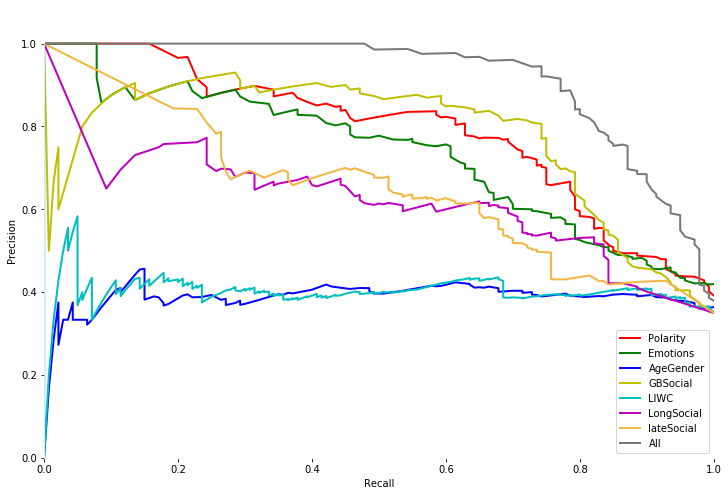

231 Normal and 121 Bipolar_3 in Training Data
26 Normal and 14 Bipolar_3 in Test Data



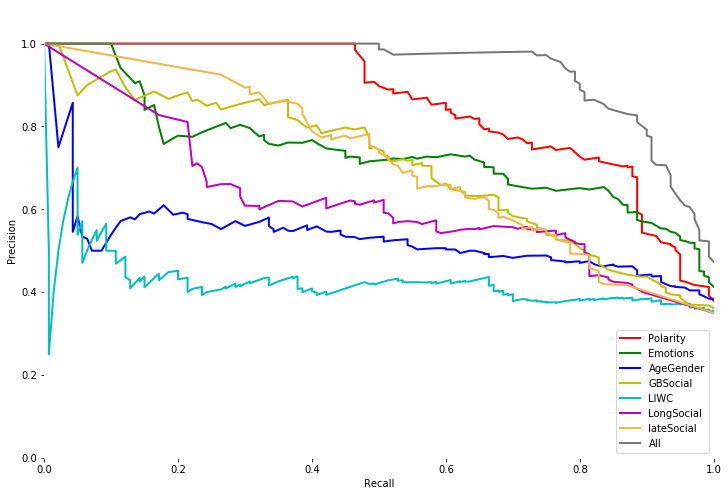

240 Normal and 111 Bipolar_6 in Training Data
27 Normal and 13 Bipolar_6 in Test Data



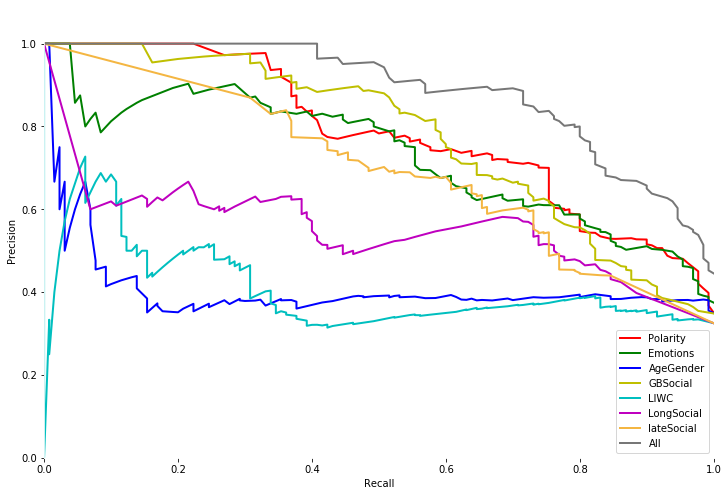

260 Normal and 105 Bipolar_9 in Training Data
29 Normal and 12 Bipolar_9 in Test Data



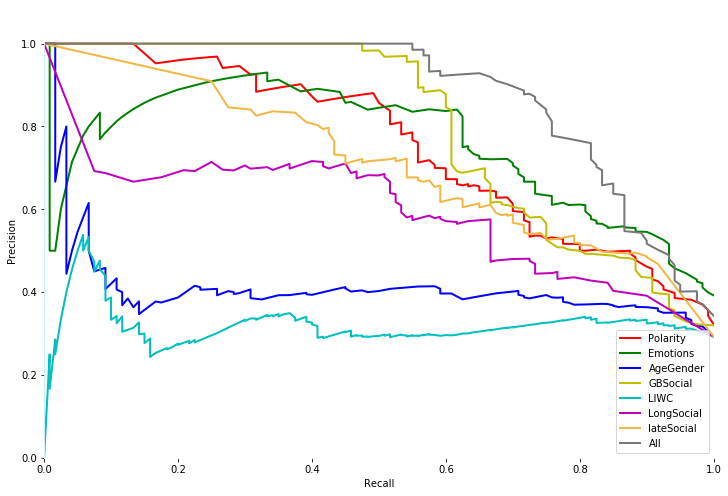

265 Normal and 100 Bipolar_12 in Training Data
30 Normal and 11 Bipolar_12 in Test Data



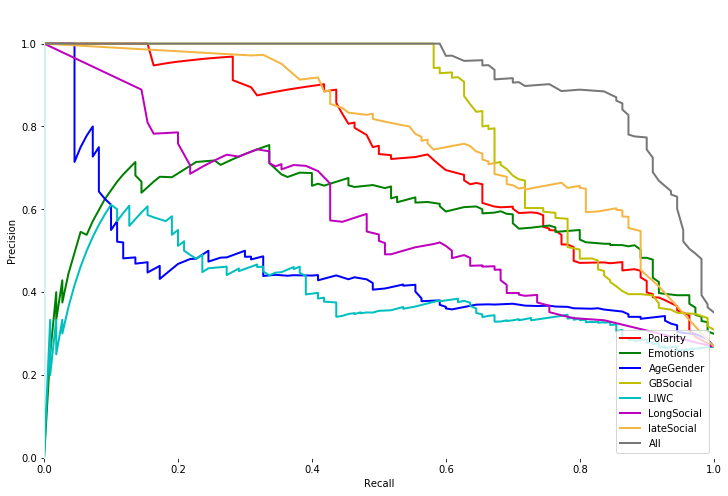

250 Normal and 100 Bipolar_15 in Training Data
28 Normal and 11 Bipolar_15 in Test Data



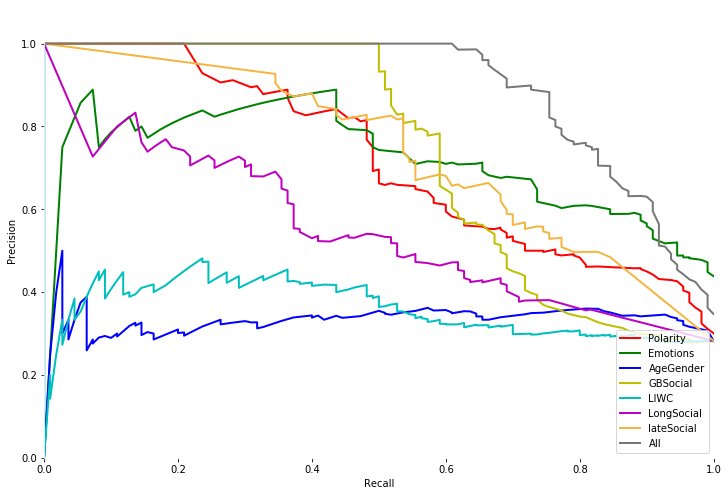

In [436]:
#Compare the performance of each Pattern of Life components and LIWC
pol_groups.renderPrecisionRecall_all("Bipolar_2", n_fold=10, consider_time = 2)
pol_groups.renderPrecisionRecall_all("Bipolar_3", n_fold=10, consider_time = 3)
pol_groups.renderPrecisionRecall_all("Bipolar_6", n_fold=10, consider_time = 6)
pol_groups.renderPrecisionRecall_all("Bipolar_9", n_fold=10, consider_time = 9)
pol_groups.renderPrecisionRecall_all("Bipolar_12", n_fold=10, consider_time = 12)
pol_groups.renderPrecisionRecall_all("Bipolar_15", n_fold=10, consider_time = 15)

# Precission Recall Chart on 10-fold cross-validation

In [437]:
pol_groups.getName2Index()

{'Bipolar_12': 10,
 'Bipolar_15': 11,
 'Bipolar_2': 6,
 'Bipolar_3': 7,
 'Bipolar_6': 8,
 'Bipolar_9': 9,
 'Regular_12': 4,
 'Regular_15': 5,
 'Regular_2': 0,
 'Regular_3': 1,
 'Regular_6': 2,
 'Regular_9': 3}

In [438]:
index2feature = pol_groups.index2feature

def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            #removed_features.append(name)
            pass
        elif any(name == x for x in excluded_index):
            #removed_features.append(name)
            pass

        else:                   
            selection.append(i)
    return selection


#ROC chart of three models:
# def renderROC(scores, labels,disorder ,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted']):
def renderROC(scores, labels,disorder ,names, linestyle=['solid','solid','solid','solid','dashdot','dashdot','dashdot','dashdot'], colors = None):
    fig, ax = plt.subplots()
    print("Under curve area")
    for i,(score, label) in enumerate(zip(scores, labels)):
        fpr, tpr, _ = roc_curve(label,score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        if colors:
            plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=3, color=colors[i])
        else:
            plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=3)

        print("\t{:15} : {}".format(names[i],roc_auc))

   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

# , linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['r','g','b',"y","c","m","#f4b642","#777777"]
# def renderPRC(scores, labels, disorder ,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = None):
def renderPRC(scores, labels, disorder ,names, linestyle=['solid','solid','solid','solid','dashdot','dashdot','dashdot','dashdot'], colors = None):
    fig, ax = plt.subplots()
    print("Average Precision")
    for i,(score, label) in enumerate(zip(scores, labels)):
        
        precision, recall, _ = precision_recall_curve(label, score, pos_label=1)
        average_precision = average_precision_score(label, score)
        if colors:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=3, color=colors[i])
        else:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=3)
            
        print("\t{:15} : {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

In [439]:

GBPOL_selection = getSelection(excluded_categories=["LIWC", "lateSocial", "LongSocial"])
latePOL_selection = getSelection(excluded_categories=["LIWC", "LongSocial"])
LongPOL_selection = getSelection(excluded_categories=["LIWC"])
LIWC_selection = getSelection(excluded_categories=["AgeGender", "Social", "Polarity", "Emotions", "lateSocial", "LongSocial"])

classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
name = "Bipolar"
n_fold = 50


In [440]:
names = ["PoL(15month)", "TFIDF(15month)", "LIWC(15month)"]

POL15_scores, POL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 15)
LIWC15_scores, LIWC15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 15)
tfidf15_scores, tfidf15_labels, _ = tfidf_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, consider_time = 15)


bipolar_SCORES = [POL15_scores, LIWC15_scores, tfidf15_scores]
bipolar_LABELS = [POL15_labels[:,0], LIWC15_labels[:,0], tfidf15_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

IndexError: index (388) out of range

In [ ]:
names = ["PoL(15month)","PoL(12month)", "PoL(9month)", "PoL(6month)","PoL(3month)", "PoL(2month)"]

POL15_scores, POL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 15)
POL12_scores, POL12_labels, _ = pol_groups.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 12)
POL9_scores, POL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 9)
POL6_scores, POL6_labels, _ = pol_groups.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 6)
POL3_scores, POL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 3)
POL2_scores, POL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 2)

bipolar_SCORES = [POL15_scores, POL12_scores, POL9_scores, POL6_scores, POL3_scores, POL2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL12_labels[:,0], POL9_labels[:,0], POL6_labels[:,0], POL3_labels[:,0], POL2_labels[:,0]]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names , linestyle=['solid','solid','solid','solid','solid','solid'])  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'])

# latePOL_scores, latePOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = "short")
# LongPOL_scores, LongPOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = "short")



In [ ]:
names = ["PoL(15month)", "PoL(9month)", "PoL(3month)", "PoL(2month)", "TFIDF(15month)", "TFIDF(9month)", "TFIDF(3month)", "TFIDF(2month)"]

POL15_scores, POL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 15)
POL9_scores, POL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 9)
POL3_scores, POL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 3)
POL2_scores, POL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 2)
tfidf15_scores, tfidf15_labels, _ = tfidf_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, consider_time = 15)
tfidf9_scores, tfidf9_labels, _ = tfidf_groups.getLabelsScores(name +"_9", classifier,n_fold=n_fold, consider_time = 9)
tfidf3_scores, tfidf3_labels, _ = tfidf_groups.getLabelsScores(name +"_3", classifier,n_fold=n_fold, consider_time = 3)
tfidf2_scores, tfidf2_labels, _ = tfidf_groups.getLabelsScores(name +"_2", classifier,n_fold=n_fold, consider_time = 2)

bipolar_SCORES = [POL15_scores, POL9_scores, POL3_scores, POL2_scores,
                  tfidf15_scores, tfidf9_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL9_labels[:,0], POL3_labels[:,0], POL2_labels[:,0], 
                  tfidf15_labels, tfidf9_labels, tfidf3_labels, tfidf2_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

# latePOL_scores, latePOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = "short")
# LongPOL_scores, LongPOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = "short")



In [ ]:
names = ["latePoL(15month)", "latePoL(9month)", "latePoL(3month)", "latePoL(2month)", "TFIDF(15month)", "TFIDF(9month)", "TFIDF(3month)", "TFIDF(2month)"]

POL15_scores, POL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 15)
POL9_scores, POL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 9)
POL3_scores, POL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 3)
POL2_scores, POL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 2)

bipolar_SCORES = [POL15_scores, POL9_scores, POL3_scores, POL2_scores,
                  tfidf15_scores, tfidf9_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL9_labels[:,0], POL3_labels[:,0], POL2_labels[:,0], 
                  tfidf15_labels, tfidf9_labels, tfidf3_labels, tfidf2_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

Under curve area
	longPoL(15month) : 0.920647107438
	longPoL(9month) : 0.939156521739
	longPoL(3month) : 0.937359047619
	longPoL(2month) : 0.918315976331
	TFIDF(15month)  : 0.796008264463
	TFIDF(9month)   : 0.842234057971
	TFIDF(3month)   : 0.535356190476
	TFIDF(2month)   : 0.90993964497


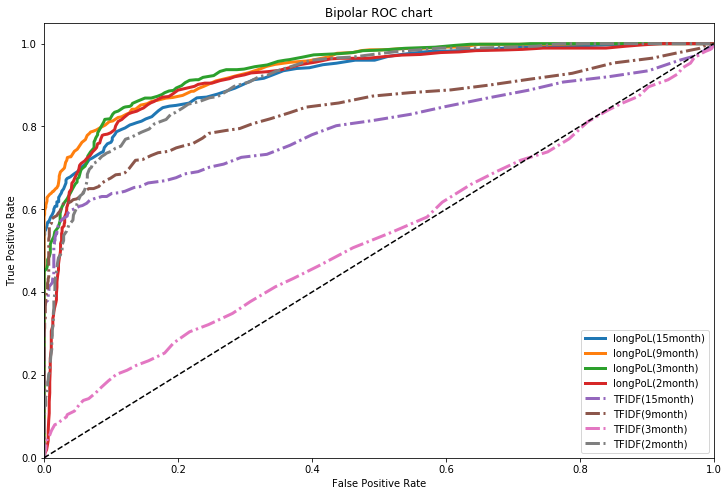

Average Precision
	longPoL(15month) : 0.890915004414
	longPoL(9month) : 0.916076910002
	longPoL(3month) : 0.938075053374
	longPoL(2month) : 0.83604365722
	TFIDF(15month)  : 0.786292691351
	TFIDF(9month)   : 0.830617472603
	TFIDF(3month)   : 0.557836212879
	TFIDF(2month)   : 0.844015604301


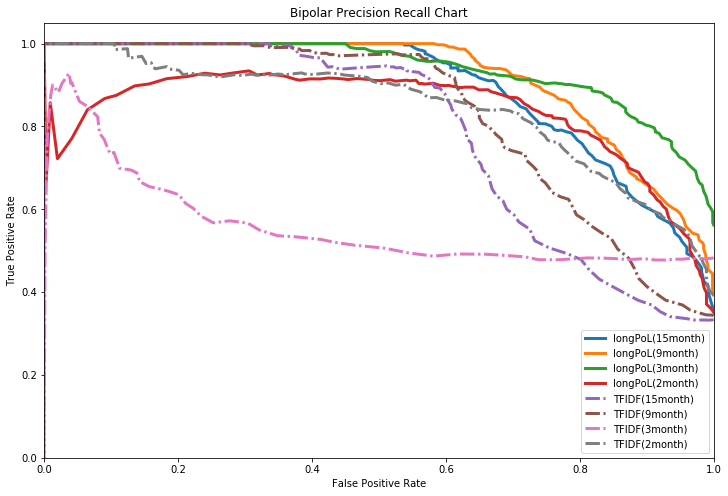

In [406]:
names = ["longPoL(15month)", "longPoL(9month)", "longPoL(3month)", "longPoL(2month)", "TFIDF(15month)", "TFIDF(9month)", "TFIDF(3month)", "TFIDF(2month)"]

POL15_scores, POL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 15)
POL9_scores, POL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 9)
POL3_scores, POL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 3)
POL2_scores, POL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 2)

bipolar_SCORES = [POL15_scores, POL9_scores, POL3_scores, POL2_scores,
                  tfidf15_scores, tfidf9_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL9_labels[:,0], POL3_labels[:,0], POL2_labels[:,0], 
                  tfidf15_labels, tfidf9_labels, tfidf3_labels, tfidf2_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

Under curve area
	PoL(GB)         : 0.983376404287
	LIWC(GB)        : 0.785348096822
	TF-IDF(GB)      : 0.842642754663
	PoL             : 0.968951469226
	time-PoL(late)  : 0.970699385367
	time-PoL        : 0.973946686874
	LIWC            : 0.862479986529
	TF-IDF          : 0.951036772487


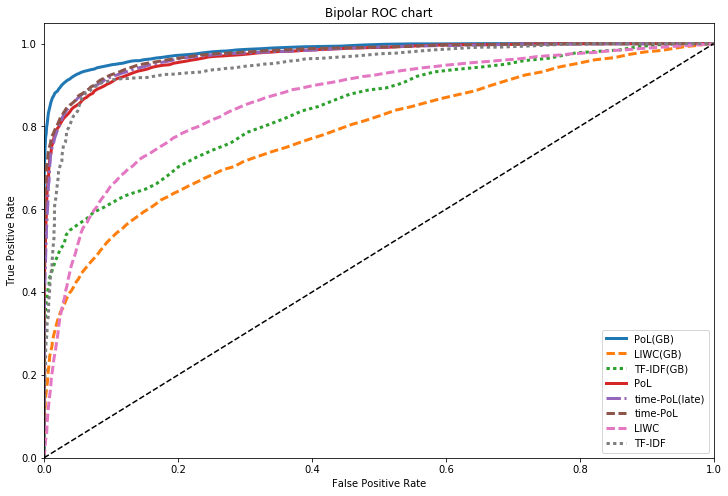

Average Precision
	PoL(GB)         : 0.971521266874
	LIWC(GB)        : 0.684552683846
	TF-IDF(GB)      : 0.778428470539
	PoL             : 0.973441501668
	time-PoL(late)  : 0.974329903413
	time-PoL        : 0.978079493269
	LIWC            : 0.865389108775
	TF-IDF          : 0.955689549733


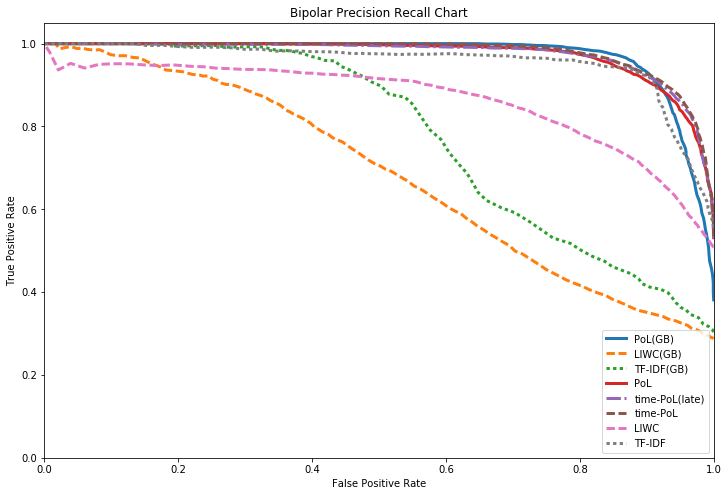

In [263]:
# Old
# names = ["PoL(GB)", "LIWC(GB)", "TF-IDF(GB)", "PoL", "time-PoL(late)", "time-PoL", "LIWC", "TF-IDF"]
# GBPOL_scores, GBPOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = "long")
# POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = "short")
# LongLIWC_scores, LongLIWC_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = "long")
# LIWC_scores, LIWC_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = "short")
# latePOL_scores, latePOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = "short")
# LongPOL_scores, LongPOL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = "short")
# Longtfidf_scores, Longtfidf_labels, _ = tfidf_groups.getLabelsScores("Long_Bipolar", classifier,n_fold=n_fold, consider_time = "long")
# tfidf_scores, tfidf_labels, _ = tfidf_groups.getLabelsScores(name, classifier,n_fold=n_fold, consider_time = "short")

# bipolar_SCORES = [GBPOL_scores, LongLIWC_scores, Longtfidf_scores, POL_scores, latePOL_scores, LongPOL_scores , LIWC_scores, tfidf_scores]
# bipolar_LABELS = [GBPOL_labels[:,0], LongLIWC_labels[:,0], Longtfidf_labels, POL_labels[:,0], latePOL_labels[:,0], LongPOL_labels[:,0], LIWC_labels[:,0], tfidf_labels]
# bipolar_NAMES =  [GBPOL_labels[:,1], LIWC_labels[:,1], latePOL_labels[:,1], POL_labels[:,1], LongPOL_labels[:,1]]

# renderROC(bipolar_SCORES, bipolar_LABELS, name,names)  
# renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

## Evaluation

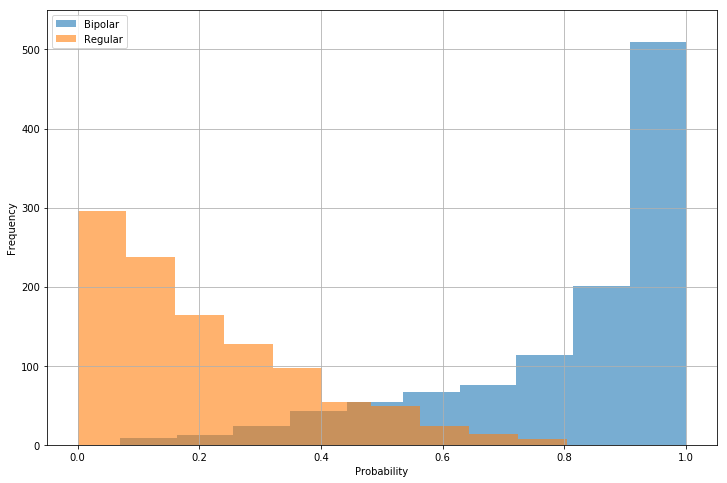

In [201]:
bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

regular_value = [bipolar_SCORES[0][i] for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

plt.hist(bipolar_value, label = 'Bipolar', alpha=0.6)
plt.hist(regular_value, label = 'Regular', alpha=0.6)

plt.grid(True)
plt.xlabel("Probability")
plt.ylabel("Frequency")

plt.ylim([0, 550])
plt.legend() 
plt.show() 
plt.close()

In [202]:
b_P_list = []
b_R_list = []
r_p_list = []
r_R_list = []
thre_list = np.arange(0.4,0.91,0.001)
for thre in thre_list:

    bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

    bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

    TP_bipolar_value = filter(lambda x: x >= thre, bipolar_value)

    regular_value = [bipolar_SCORES[0][i]for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

    TN_regular_value = filter(lambda x: x < thre, regular_value)

    Total_Bipolar = len(bipolar_value)

    Total_Regular = len(regular_value)

    FP = Total_Regular - len(TN_regular_value)

    FN = Total_Bipolar - len(TP_bipolar_value)

    b_P = float(len(TP_bipolar_value))/(len(TP_bipolar_value) + FP)
    b_R = float(len(TP_bipolar_value))/len(bipolar_value)
    r_p = float(len(TN_regular_value))/(len(TN_regular_value) + FN)
    r_R = float(len(TN_regular_value))/len(regular_value)

    b_P_list.append(b_P)
    b_R_list.append(b_R)
    r_p_list.append(r_p)
    r_R_list.append(r_R)


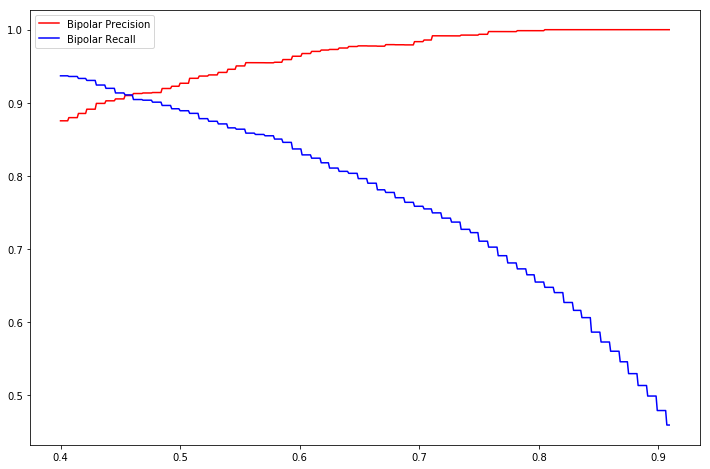

In [203]:
plt.plot(thre_list, b_P_list, 'r', label='Bipolar Precision')
plt.plot(thre_list, b_R_list, 'b', label='Bipolar Recall')
plt.legend()
plt.show() 
plt.close()

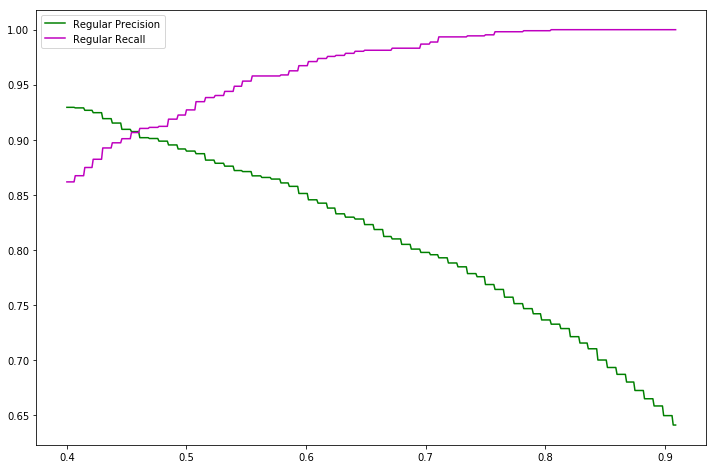

In [204]:
plt.plot(thre_list, r_p_list, 'g', label='Regular Precision')
plt.plot(thre_list, r_R_list, 'm', label='Regular Recall')
plt.legend()
plt.show() 
plt.close()

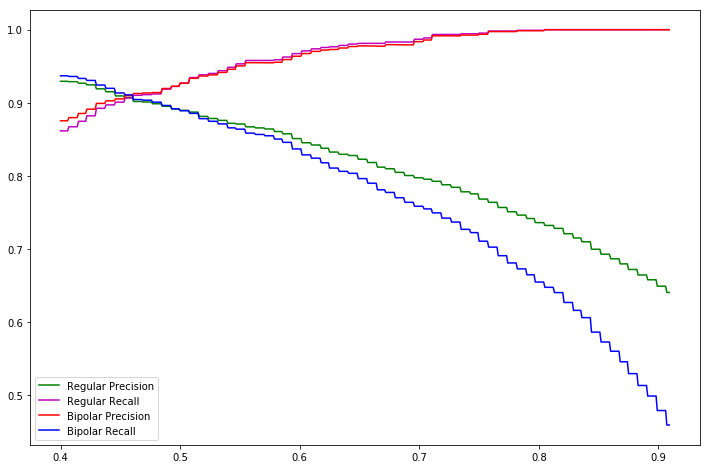

In [205]:
plt.plot(thre_list, r_p_list, 'g', label='Regular Precision')
plt.plot(thre_list, r_R_list, 'm', label='Regular Recall')
plt.plot(thre_list, b_P_list, 'r', label='Bipolar Precision')
plt.plot(thre_list, b_R_list, 'b', label='Bipolar Recall')
plt.legend()
plt.show() 
plt.close()

In [206]:
for i, value in enumerate(thre_list):
    if b_P_list[i] < r_R_list[i]:
        cross_i = i
        upper_bound = thre_list[i]
        print upper_bound
        break
for i, value in enumerate(thre_list):
    if r_p_list[i] < b_P_list[i]:
        
        lower_bound = thre_list[i]
        print lower_bound
        break

0.5
0.454


Bipolar Precision: 0.92676056338
Bipolar Recall: 0.889189189189


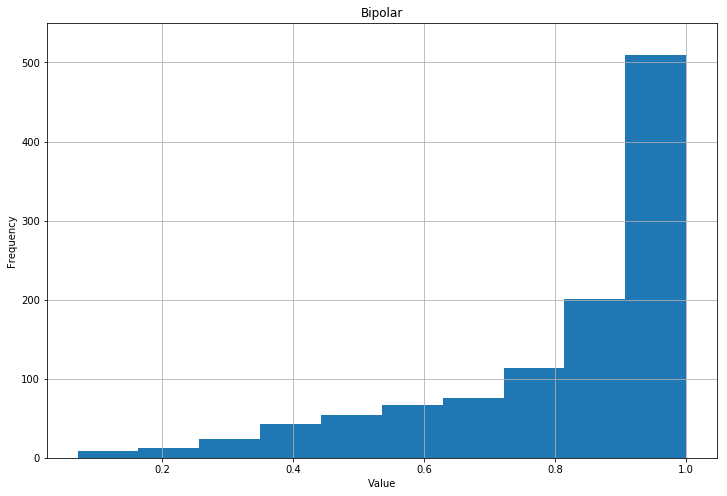

Regular Precision: 0.889686098655
Regular Recall: 0.927102803738


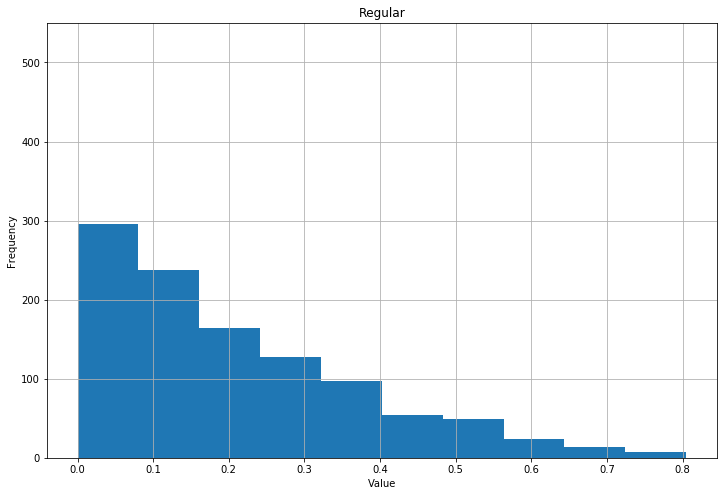

In [251]:
print('Bipolar Precision: {}'.format(b_P_list[cross_i]))
print('Bipolar Recall: {}'.format(b_R_list[cross_i]))
plt.hist(bipolar_value)
plt.grid(True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Bipolar")
plt.ylim([0, 550])
# plt.xlim([0.4, 0.9])
plt.show()
plt.close()

print('Regular Precision: {}'.format(r_p_list[cross_i]))
print('Regular Recall: {}'.format(r_R_list[cross_i]))
plt.hist(regular_value)
plt.grid(True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Regular")
plt.ylim([0, 550])
# plt.xlim([0.4, 0.9])
plt.show() 
plt.close()

Bipolar Precision: 0.911602209945
Bipolar Recall: 0.927835051546

Regular Precision: 0.926174496644
Regular Recall: 0.909604519774


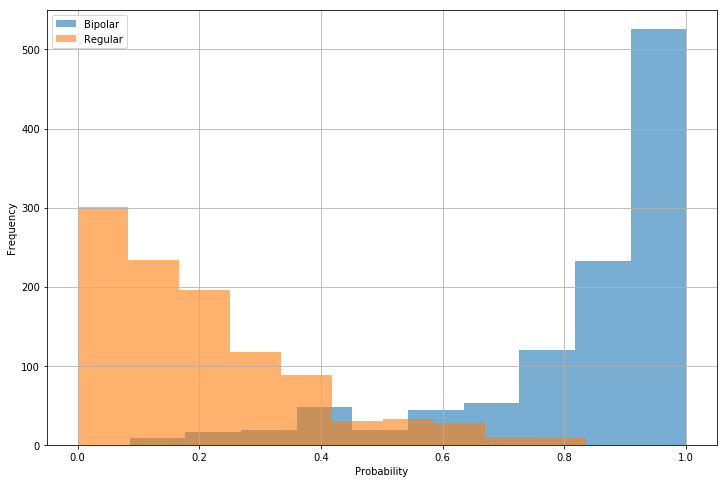

In [252]:
# Cut in different value

bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

TP_bipolar_value = filter(lambda x: x >= upper_bound, bipolar_value)

regular_value = [bipolar_SCORES[0][i] for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

TN_regular_value = filter(lambda x: x < lower_bound, regular_value)

FP = len(filter(lambda x: x < lower_bound, bipolar_value))

FN = len(filter(lambda x: x >= upper_bound, regular_value))

b_P = float(len(TP_bipolar_value))/(len(TP_bipolar_value) + FP)
b_R = float(len(TP_bipolar_value))/(len(TP_bipolar_value)+FN )
r_p = float(len(TN_regular_value))/(len(TN_regular_value) + FN)
r_R = float(len(TN_regular_value))/(len(TN_regular_value)+ FP)

print('Bipolar Precision: {}'.format(b_P))
print('Bipolar Recall: {}'.format(b_R))
print 
print('Regular Precision: {}'.format(r_p))
print('Regular Recall: {}'.format(r_R))

plt.hist(filter(lambda x: x >= upper_bound or x < lower_bound, bipolar_value), label = 'Bipolar', alpha=0.6)
plt.hist(filter(lambda x: x >= upper_bound or x < lower_bound, regular_value), label = 'Regular', alpha=0.6)

plt.grid(True)
plt.xlabel("Probability")
plt.ylabel("Frequency")

plt.ylim([0, 550])
plt.legend() 
plt.show() 
plt.close()

# Check Polarity user

In [209]:
from collections import Counter

In [210]:
under_lower_index = [i for i in bipolar_index if bipolar_SCORES[0][i] < lower_bound]
under_lower_user = [(pol_groups.getGroupUserName()[int(bipolar_NAMES[0][i])], bipolar_SCORES[0][i]) for i in under_lower_index]
# Counter([name for name, value in under_lower_user]).most_common()


## BD user Predict < 0.3

In [211]:
Counter([name for name, value in filter(lambda x: x[1]<0.3 ,under_lower_user)]).most_common()

[('yohaw', 6),
 ('PunkRockHappy', 5),
 ('clyder1966', 4),
 ('TommmMate', 3),
 ('_kenziiieee_', 3),
 ('NiallBunny', 2),
 ('Megrrrs', 2),
 ('Boricua611', 2),
 ('enjoyscarlett_', 2),
 ('Radica_XO_Khidd', 1),
 ('AwesomeAsh', 1),
 ('TWallaceMusic', 1),
 ('ghostofclifford', 1),
 ('LochnessaMarie', 1)]

## Regular user Predict > 0.7

In [212]:
regular_index = [i for i in xrange(len(bipolar_SCORES[0])) if i not in bipolar_index]
on_upper_index = [i for i in regular_index if bipolar_SCORES[0][i] > upper_bound]
on_upper_user = [(pol_groups.getBaseUserName()[int(bipolar_NAMES[0][i])], bipolar_SCORES[0][i]) for i in regular_index]
# Counter([name for name, value in on_upper_user]).most_common()


In [234]:
Counter([name for name, value in filter(lambda x: x[1]>0.7 ,on_upper_user)]).most_common()

[(2847673069, 3),
 (118151476, 3),
 (85093166, 2),
 (2905542613, 2),
 (258224151, 2),
 (453767970, 1),
 (356860297, 1)]

In [233]:
# for i, user in enumerate(regular_clean):
#     if user['name'][0] != 118151476:continue
#     print i

In [232]:
# regular_clean[152]

## Testing Predict Model

In [42]:
def getPOLFeature(timeSeries):
#     features = np.zeros((len(user_timeSeries_list),20),dtype=float)
    features = np.zeros((20),dtype=float)
        
    tweets_length = float(timeSeries.shape[0])
    tweets_rate = getTweetRate(timeSeries)
    late_tweets_rate = getLateTweetRate(timeSeries)
    mention_rate = getMentionRate(timeSeries)
    unique_mentions = getUniqueMentions(timeSeries)
    frequent_mentions = getFrequentMentions(timeSeries)
    negative_ratio = getNegativeRatio(timeSeries)
    positive_ratio = getPositiveRatio(timeSeries)
    flips_ratio = getFlipsCount(timeSeries) / tweets_length
    negative_combos = getCombosCount(timeSeries,matcher=-1) / tweets_length
    positive_combos = getCombosCount(timeSeries,matcher=1) / tweets_length
    emotion_counts_dict = getUsersEmotions(timeSeries)


    age = getAge(timeSeries)
    gender = getGender(timeSeries)

    features[0] = tweets_rate
    features[1] = late_tweets_rate
    features[2] = mention_rate
    features[3] = unique_mentions
    features[4] = frequent_mentions 
    features[5] = positive_ratio
    features[6] = negative_ratio
    features[7] = flips_ratio
    features[8] = negative_combos
    features[9] = positive_combos
    features[10] = age
    features[11] = gender
    for j, emotion in enumerate(["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]):
        features[12+j] = np.mean(emotion_counts_dict[emotion])
        
            
    return features

In [222]:
# #Dump the pre-trained models

# # Get feature
feature_order = ['tweets_rate', 'late_tweets_rate','mention_rate','unique_mentions','frequent_mentions','positive_ratio',\
                 'negative_ratio','flips','negative_combos','positive_combos', 'age', 'gender', "joy","sadness","fear",  \
                 "anticipation", "anger", "trust", "disgust" ,"surprise", "long_tweets_rate"]
online_selection = []

for feature_name in feature_order:
    for i,(name, category) in enumerate(pol_groups.index2feature):
        if name == feature_name:
            online_selection.append(i)
print(online_selection)
            
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

X, Y = pol_groups.getLabeledData("Bipolar", selection=online_selection)

sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.4, random_state=randint(0,65536) )

for train_index, test_index in sss:
    X_train, X_test           = X[train_index], X[test_index]
    Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]
    Y_train_name, Y_test_name = Y[train_index][:,1], Y[test_index][:,1]

    classifier.fit(X_train, Y_train)

SCORES = [classifier.predict_proba(X_test)[:,1]]
LABELS = [Y[test_index][:,0]]

[7, 19, 11, 3, 18, 6, 0, 8, 20, 2, 5, 13, 4, 10, 16, 1, 14, 17, 12, 15, 9]


Pattern of Life Average Precision: 0.974806061141


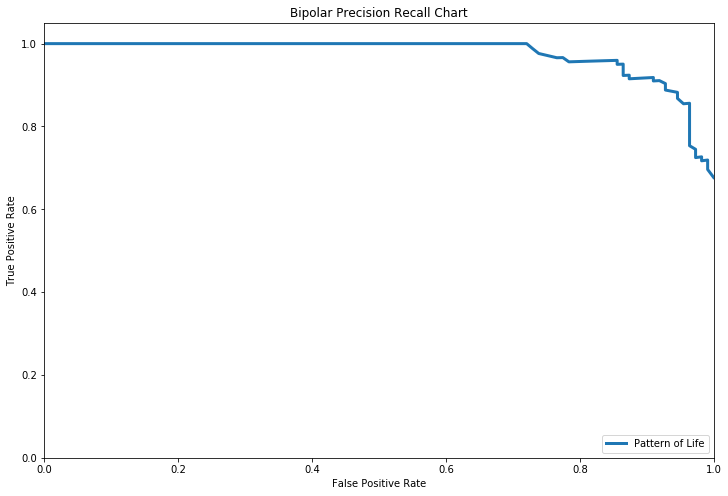

In [249]:
renderPRC(SCORES, LABELS, "Bipolar", ["Pattern of Life"])

In [250]:
#joblib.dump(classifier,"models/bipolar_forest/bipolar_forest_long_term")

['models/bipolar_forest/bipolar_forest_long_term',
 'models/bipolar_forest/bipolar_forest_long_term_01.npy',
 'models/bipolar_forest/bipolar_forest_long_term_02.npy',
 'models/bipolar_forest/bipolar_forest_long_term_03.npy',
 'models/bipolar_forest/bipolar_forest_long_term_04.npy',
 'models/bipolar_forest/bipolar_forest_long_term_05.npy',
 'models/bipolar_forest/bipolar_forest_long_term_06.npy',
 'models/bipolar_forest/bipolar_forest_long_term_07.npy',
 'models/bipolar_forest/bipolar_forest_long_term_08.npy',
 'models/bipolar_forest/bipolar_forest_long_term_09.npy',
 'models/bipolar_forest/bipolar_forest_long_term_10.npy',
 'models/bipolar_forest/bipolar_forest_long_term_11.npy',
 'models/bipolar_forest/bipolar_forest_long_term_12.npy',
 'models/bipolar_forest/bipolar_forest_long_term_13.npy',
 'models/bipolar_forest/bipolar_forest_long_term_14.npy',
 'models/bipolar_forest/bipolar_forest_long_term_15.npy',
 'models/bipolar_forest/bipolar_forest_long_term_16.npy',
 'models/bipolar_fore

## Check the Feature Order

In [44]:
for cursor, (name,category) in enumerate(pol_groups.getIndex2Feature()):
    print '{}\t{}\t{}'.format(cursor, name, category)

0	negative_ratio	Polarity
1	anticipation	Emotions
2	positive_combos	Polarity
3	unique_mentions	Social
4	joy	Emotions
5	age	AgeGender
6	positive_ratio	Polarity
7	tweets_rate	Social
8	flips	Polarity
9	sadness	Emotions
10	mention_rate	Social
11	disgust	Emotions
12	gender	AgeGender
13	anger	Emotions
14	surprise	Emotions
15	fear	Emotions
16	trust	Emotions
17	frequent_mentions	Social
18	late_tweets_rate	Social
19	negative_combos	Polarity


## Check Testing Result

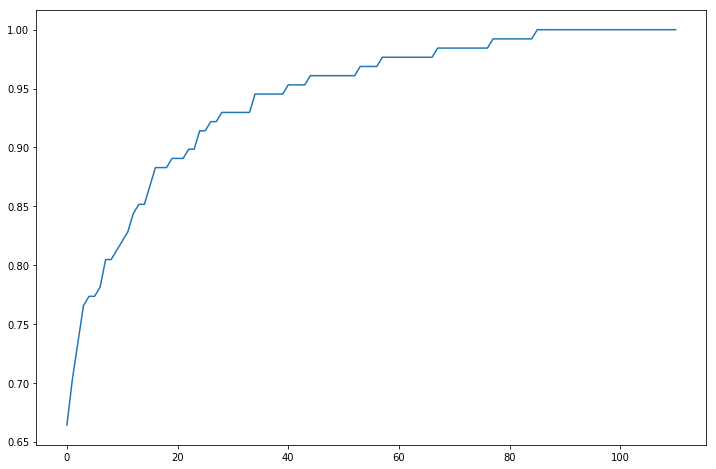

In [63]:
bd_testing_list = []
for i, lab in enumerate(LABELS):
    if lab[0] == 1:
        bd_testing_list.append(SCORES[i])
plt.plot(sorted(bd_testing_list))
plt.show()
plt.close()    

## Check Training Result

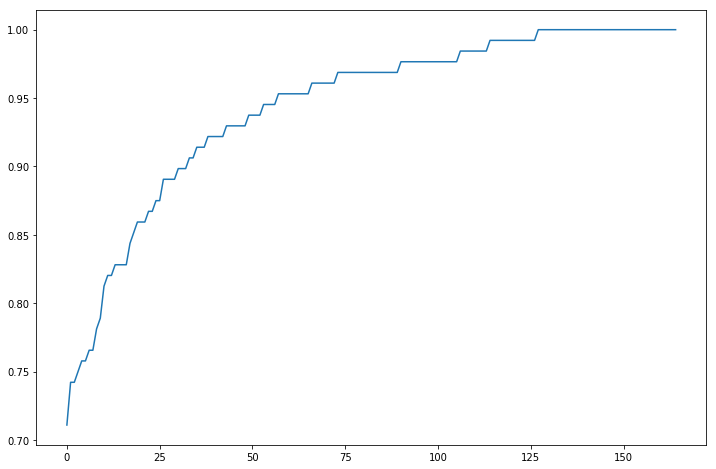

In [65]:
bd_testing_list = []
train_score = classifier.predict_proba(X_train)[0][:,1]
for i, lab in enumerate(Y[train_index]):
    if lab[0] == 1:
        bd_testing_list.append(train_score[i])
plt.plot(sorted(bd_testing_list))
plt.show()
plt.close()   

## Check Original BD user Dataset

In [66]:
# proba_list = []
# for timeSeries in bd_clean:
#     bd_features = getPOLFeature(timeSeries)
#     bd_proba = classifier.predict_proba(bd_features)[0][1]
#     proba_list.append(bd_proba)
    
# plt.plot(sorted(proba_list))
# plt.show()
# plt.close()
